In [19]:
# Generic stuff
from IPython.display import IFrame

# Numerical stuff
import numpy as np

# Viz
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter

# Optimal transport and Wasserstein distance

This note book has been inspired by the following sources:
* [this wikipedia article](https://en.wikipedia.org/wiki/Wasserstein_metric)
* A very nice serie of blog articles:
    * [introduction](http://modelai.gettysburg.edu/2020/wgan/Resources/Lesson4/IntuitiveGuideOT1.htm)
    * [Wassertein GAN](http://modelai.gettysburg.edu/2020/wgan/Resources/Lesson4/IntuitiveGuideOT.htm)


* [The original wasserstein GAN paper](http://www.stat.cmu.edu/~larry/=sml/Opt.pdf)
https://arxiv.org/abs/1701.07875

In [1]:
#IFrame("doc/OptimalTransportWasserteinDistance/wassersteinGAN.pdf", width=1200, height=800)

* An elementary introduction to entropic regularization and proximal methods for numerical optimal transport

In [2]:
#IFrame("doc/OptimalTransportWasserteinDistance/CourseOT.pdf", width=1200, height=800)

* A PhD thesis on "Entropic Optimal Transport in Machine Learning: applications to Distributional Regression, Barycentric Estimation and Probability Matching"

In [3]:
#IFrame("doc/OptimalTransportWasserteinDistance/PhD_thesis__LUISEGIULIA.pdf", width=1200, height=800)

* [This short course from Carnegie Mellon University](http://www.stat.cmu.edu/~larry/=sml/Opt.pdf)

In [4]:
#IFrame("doc/OptimalTransportWasserteinDistance/optimal_transport.pdf", width=1200, height=800)

* Gabriel Peyre did a great set of slides to present this problem

In [35]:
#IFrame("doc/OptimalTransportWasserteinDistance/peyre_slides.pdf", width=1200, height=800)

* Gabriel Peyre also published a very nice review paper, together with Cuturi, on this problem and its applications in large machine learning problems:

In [36]:
#IFrame("doc/OptimalTransportWasserteinDistance/peyre_cuturi_review_paper.pdf"", width=1200, height=800)

### List of videos on the topic:

* Marco Cuturi (Google DeepMind) [course from 2019](https://www.youtube.com/watch?v=6iR1E6t1MMQ&ab_channel=MLSSAfrica)
* Marco Cuturi (Google DeepMind) [course from 2020](https://www.youtube.com/watch?v=jgrkhZ8ovVc&ab_channel=virtualmlss2020)
* Uni heldelberg series of courses on Optimal Transport:[part 1](https://www.youtube.com/watch?v=ASTGFZ0d6Ps&ab_channel=UniHeidelberg)
* Uni heldelberg series of courses on Optimal Transport:[part 2](https://www.youtube.com/watch?v=VY0syny-o1M&ab_channel=UniHeidelberg)
* Uni heldelberg series of courses on Optimal Transport:[part 3](https://www.youtube.com/watch?v=BfOjrQAhG4M&ab_channel=UniHeidelberg)

## Introduction from Mindcodec

### Basic introduction

This content is a reproduction from [mindcodec website](http://modelai.gettysburg.edu/2020/wgan/Resources/Lesson4/IntuitiveGuideOT1.htm) all credit for this part pertains to the author.

Optimal transport problems can be formulated in a very intuitive way. Consider the following example: an online retailer has $N$ warehouses and there are $K$ customers who ordered e-book readers. The n-th storage area $x_n$
contains $m_n$ readers while the k-th customer $y_k$ ordered $h_k$ readers. The transport cost $c(x,y)$ is the distance between the storage area $x$ and the address of customer $y$.
The optimal transport problem consists of finding the least expensive way of moving all the readers stored in the storage areas to the customers who ordered them.
A transportation map $\Gamma$ is a matrix whose $\Gamma_{nk}$ entry represents the number of e-book readers sent from the n-th storage area to the k-th customer. For consistency, the sum of all the readers leaving the n-th storage areas has to be equal to the total number of readers stored in that area while the sum of all the readers arriving to a customer’s house has to be equal to the number of e-book readers she ordered. These are the hard constraints of the transport problem and can be written in formulas as follows:

\begin{align*}
  \sum_{k} \Gamma_{nk} = m_n
\end{align*}
and
\begin{align*}
  \sum_{n} \Gamma_{nk} = h_k
\end{align*}

The final constraint is that the entries of the matrix have to be positive-valued (for obvious reasons). The optimal solution is the transportation matrix that minimizes the total cost while respecting the constraints:

\begin{align*}
  \hat{T} = \underset{\Gamma \in \mathbb{R}^{N\times K+}}{argmin} \sum \Gamma_{nk} c(x_n, y_k)
\end{align*}

In this expression we are assuming that transporting L e-readers from $x_n$ to $y_k$ is $L$ times more expensive than transporting one reader. Note that this assumption is not realistic in most real world transportation problems since the transportation cost usually does not scale linearly with the number of transported units. Nevertheless, this simplified problem gives rise to a very elegant and useful mathematical theory.

### Probabilistic formulation
In machine learning and statistics it is often useful to reformulate the optimal transport problem in probabilistic terms. Consider two finite probability spaces $(X, P)$ and $(Y, Q)$ where $X$ and $Y$ are finite sets and $P$ and $Q$ are probability functions assigning a probability to each element of their set. The optimal transport between $P$ and $Q$ is the conditional probability function $\Gamma(y|x)$ that minimizes the following cost function:

\begin{align*}
  \underset{\Gamma}{argmin} \sum \Gamma(y_n|x_k) P(x_k) c(x_n, y_k)
\end{align*}
subject to the following marginalization constraint:
\begin{align*}
  \sum \Gamma(y_n|x_k) P(x_k) = Q(y_n)
\end{align*}
This simply means that the marginal distribution of the joint probability $\Gamma(y_n|x_k) P(x_k)$ is $Q(y_n)$

In other words, $\Gamma(y_n|x_k)$ is transporting the distribution $P(x)$ into the distribution $Q(y)$.
This transportation can be interpreted as a stochastic function that takes $x$ as input and outputs a $y$
 with probability $γ\Gamma(y|x)$. The problem thus consists of finding a stochastic transport that maps the probability distribution $P$ into the probability distribution $Q$ while minimizing the expected transportation cost. It is easy to see that this problem is formally identical to the deterministic problem that I introduced in the previous section. The transportation matrix $\Gamma_{nk}$ is given by $\Gamma(y_n|x_k) P(x_k)$.
This ensures that the first constraint (number of ebook per warehouse) is automatically fulfilled while the second constraint (number of ebook per customer) still needs to be enforced.

### Continuous formulation
It is straightforward to extend the definition of probabilistic optimal transport to continuous probability distributions. This can be done by replacing the probabilities $P(x)$ and $Q(x)$ with the probability densities 
$p(x)$ and $q(x)$ and the summation with an integration:

\begin{align*}
  \underset{\gamma}{argmin} \int \gamma(y|x) p(x) c(x, y) dxdy
\end{align*}

Analogously, the marginalization constraint becomes:
\begin{align*}
  \int \gamma(y|x) p(x) dx = q(y)
\end{align*}

This continuous optimal transport problem is usually introduced in a slightly different (and in my opinion less intuitive) form. I will denote the joint density $\gamma(y|x) p(x)$ as $\gamma(x,y)$.
It is easy to see that the problem can be reformulated as follows:

\begin{align*}
  \underset{\gamma}{argmin} \int \gamma(x,y) c(x, y) dxdy
\end{align*}

with the two marginalization constraints:
\begin{align*}
  \int \gamma(x,y)dx = q(y)
\end{align*}
and
\begin{align*}
  \int \gamma(x,y)dy = p(x)
\end{align*}

### Optimal transport divergences
In many situations the primary interest is not to obtain the optimal transportation map. Instead, we are often interested in using the optimal transportation cost as a statistical divergence between two probability distributions. A statistical divergence is a function that takes two probability distributions as input and outputs a non-negative number that is zero if and only if the two distributions are identical. Statistical divergences such as the $KL$ divergence are massively used in statistics and machine learning as a way of measuring dissimilarity between two probability distributions. Statistical divergences have a central role in several of the most active areas of statistical machine learning, such as generative modeling and variational Bayesian inference.

### Optimal transport divergences and the Wasserstein distance
An optimal transport divergence is defined as the optimal transportation cost between two probability distributions:

\begin{align*} 
  OT_c[p,q] = \underset{\gamma}{inf} \int \gamma(x,y) c(x,y) dxdy
\end{align*}

where the optimization is subject to the usual marginalization constraints. This expression provides a valid divergence as far as the cost is always non-negative and $c(x,x)$ vanishes for all values of $x$. Clearly, the properties of an optimal transport divergence depend on its cost function. A common choice is the squared Euclidean distance:

\begin{align*}
  c(x,y) = \|x-y\|_2^2
\end{align*}

Using the Euclidean distance as a cost function, we obtain the famous (squared) 2-Wasserstein distance:

\begin{align*} 
  W_2[p,q]^2 = \underset{\gamma}{inf} \int \gamma(x,y) \|x-y\|_2^2 dxdy
\end{align*}

The squared root of $W_2[p,q]^2$ is a proper metric function between probability distributions as it respects the triangle inequality. Using a proper metric such as the Wasserstein distance instead of other kinds of optimal transport divergences is not crucial for most machine learning applications, but it often simplifies the mathematical treatment. Finally, given an integer $k$, the k-Wasserstein distance is defined as follows:

\begin{align*} 
  W_k[p,q]^k = \underset{\gamma}{inf} \int \gamma(x,y) \|x-y\|_k^k dxdy
\end{align*}
 
where $\|\cdot\|_k^k$ denotes the $L_k$ norm.

### A practical example of 1-Wasserstein distance calculation
We show hereafter a very simple example of the use of scipy.stats module to compute wasserstein distance between two 1-dimensional distribution functions.

This is an abstract from the documentation:

#####  scipy.stats.wasserstein_distance(u_values, v_values, u_weights=None, v_weights=None)
Compute the first Wasserstein distance between two 1D distributions.

This distance is also known as the earth mover’s distance, since it can be seen as the minimum amount of “work” required to transform  into , where “work” is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

New in version 1.0.0.

##### Parameters
u_values, v_valuesarray_like
Values observed in the (empirical) distribution.

##### u_weights, v_weightsarray_like, optional
Weight for each value. If unspecified, each value is assigned the same weight. u_weights (resp. v_weights) must have the same length as u_values (resp. v_values). If the weight sum differs from 1, it must still be positive and finite so that the weights can be normalized to sum to 1.

##### Returns
distancefloat
The computed distance between the distributions.


The input distributions can be empirical, therefore coming from samples whose values are effectively inputs of the function, or they can be seen as generalized functions, in which case they are weighted sums of Dirac delta functions located at the specified values.

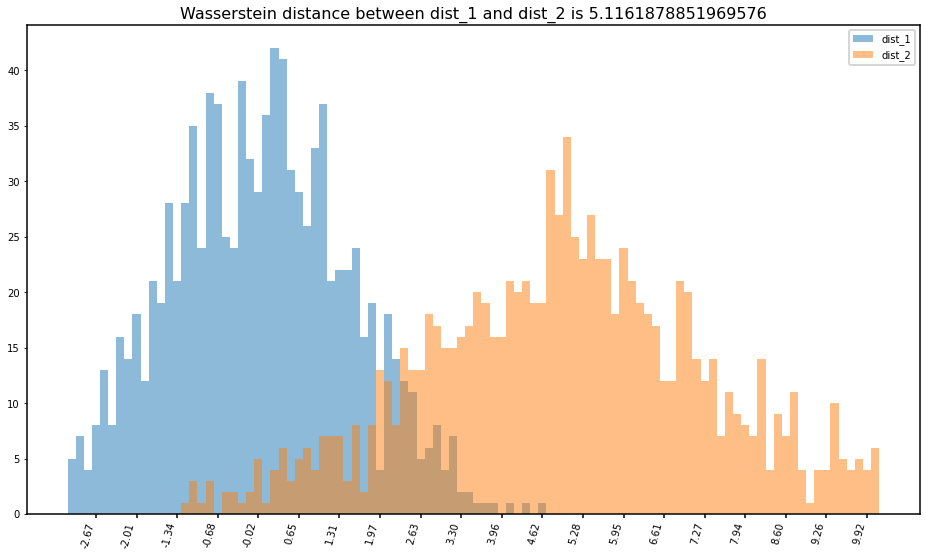

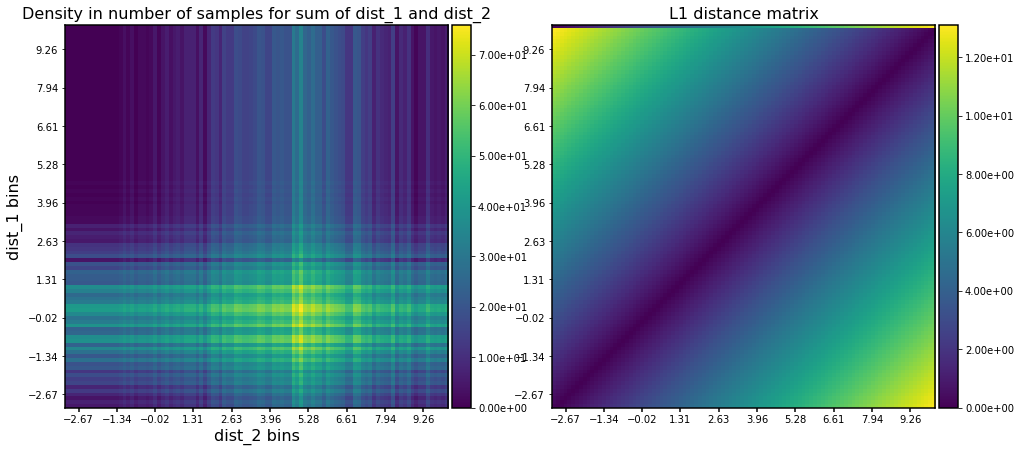

In [34]:
from scipy.stats import wasserstein_distance

nb_samples = 1024
nb_bins = 100
mu_1 = 0
mu_2 = 5
sigma_1 = 1.5
sigma_2 = 2.5
dist_1 = np.random.normal(loc=mu_1, scale=sigma_1, size=nb_samples)
dist_2 = np.random.normal(loc=mu_2, scale=sigma_2, size=nb_samples)

# Show hist
min_99_perc = np.percentile(np.concatenate((dist_1, dist_2)), 1)
max_99_perc = np.percentile(np.concatenate((dist_1, dist_2)), 99)
#bins = np.linspace(min_99_perc, max_99_perc, nb_bins+1)
hist_1, bins = np.histogram(dist_1, bins=nb_bins, range=[min_99_perc, max_99_perc], density=False)
hist_2, bins = np.histogram(dist_2, bins=nb_bins, range=[min_99_perc, max_99_perc], density=False)
width_bins = np.diff(bins)
center_bins = (bins[:-1] + bins[1:]) / 2


fig, ax = plt.subplots(figsize=(16,9))
#If bins is a sequence, it defines the bin edges, including the left edge of the first bin and the right edge of the last bin
#ax.hist(dist_1, bins, alpha=0.5, label='dist_1')
ax.bar(center_bins, hist_1, align='center', width=width_bins, alpha=0.5, label='dist_1')
#ax.hist(dist_2, bins, alpha=0.5, label='dist_2')
ax.bar(center_bins, hist_2, align='center', width=width_bins, alpha=0.5, label='dist_2')
ax.set_xticks(center_bins)
ax.set_xticklabels(map(lambda x: f"{x:.2f}", center_bins), rotation = 75, ha="right")
ax.locator_params(nbins=20, axis='x')
ax.legend(loc='upper right')
ax.set_title(f"Wasserstein distance between dist_1 and dist_2 is {wasserstein_distance(dist_1, dist_2)}")

# Define density on both axis
density = np.repeat(hist_1.reshape(-1,1)[::-1], len(bins)-1, axis=1)
density += np.repeat(hist_2.reshape(-1,1), len(bins)-1, axis=1).T

# Define distance matrix
dist_mat = np.zeros((len(bins)-1, len(bins)-1))
for idx_1, (bin_1_min, bin_1_max) in enumerate(zip(bins[:-1], bins[1:])):
    for idx_2, (bin_2_min, bin_2_max) in enumerate(zip(bins[:-1], bins[1:])):
        bin_1_mean = (bin_1_min+bin_1_max)/2
        bin_2_mean = (bin_2_min+bin_2_max)/2
        dist_mat[-idx_1, idx_2] = np.abs(bin_1_mean-bin_2_mean)
fig, ax = plt.subplots(1,2, figsize=(16,9))

# Plot density
#[xmin,xmax,ymin,ymax]
extent = [bins[0], bins[-1], bins[0], bins[-1]]
heatmap = ax[0].imshow(density, extent=extent)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(heatmap, format=FormatStrFormatter('%.2e'), cax=cax)
ax[0].set_xlabel("dist_2 bins")
ax[0].set_ylabel("dist_1 bins")
ax[0].set_xticks(center_bins)
ax[0].set_yticks(center_bins)
ax[0].locator_params(nbins=10, axis='both')
ax[0].set_title(f"Density in number of samples for sum of dist_1 and dist_2")

# Plot distance
heatmap = ax[1].imshow(dist_mat, extent=extent)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(heatmap, format=FormatStrFormatter('%.2e'), cax=cax)
#ax[1].axis('off')
ax[0].set_xlabel("dist_2 bins")
ax[0].set_ylabel("dist_1 bins")
ax[1].set_xticks(center_bins)
ax[1].set_yticks(center_bins)
ax[1].locator_params(nbins=10, axis='both')
ax[1].set_title(f"L1 distance matrix")

plt.show()


In [ ]:
# A practical application in the discrete case with mixed integer programming library MIP:


In [ ]:
# A practical application with hungarian algorithm
# Example inspired from scipy documentaiton: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html

### The dual problem and the Wasserstein GAN
Optimal transport problems are a special case of linear programming problems since both the function to be optimized and the constraints are linear functions of the transportation map. The theory behind linear programming dates back to the beginning of the last century and is one of the cornerstones of mathematical optimization. One of the most fundamental results of linear programming is that any linear problem has a dual problem whose solution provides an upper bound to the solution of the original (primal) problem. Fortunately, it turns out that in the case of optimal transport the solution of the dual problem does not simply provide a bound but is indeed identical to the solution of the primal problem. Furthermore, the dual formulation of the optimal transport problem is the starting point for adversarial algorithms and the Wasserstein GAN. The dual formulation of an optimal transport divergence is given by the following formula:


\begin{align*} 
  OT_c[p,q] = \underset{f \in L_c}{sup} \left[\int_x f(x)p(x)dx - \int_y f(y)q(y)dy \right]
\end{align*}

where $L_c$ is the set of functions whose growth is bounded by $c$:

\begin{align*} 
  L_c = \{ f: \mathbb{R} \rightarrow \mathbb{R} | f(x)-f(y)\leq c(x,y) \}
\end{align*} 

It is far from obvious why this expression is equivalent to the primal expression that I gave in the previous sections and I will spend the rest of the post proving this result. However, the formula in itself has a rather intuitive interpretation. Clearly, if $p$ is equal to $q$, the difference between their expected values of any function $f$ will be zero and consequently the divergence will vanish. Now assume that $p$ and $q$ differ in some region of their domain. In this case the divergence is obtained by finding the function $f$ that maximizes this difference in terms of its expected value. In other words, $f$ acts like a feature detector that extract the features that maximally differentiate $p$ from $q$.

For example, imagine that $p$ is a distribution over landscape images without traces of human activity while $q$
is a distribution over landscape images with a plane in the sky. In this case, the optimal $f$ will be a plane detector. From this example you can see how $f$ plays the role of a discriminator in the Wasserstein GAN. Note that without any constraints on $f$ any small difference in the distributions can be magnified arbitrarily and the divergence would be infinite.

### Proving the duality

In order to prove the duality, we need to reformulate the constrained optimization in the primal problem as an unconstrained one. Consider the following optimization:

\begin{align*} 
  \underset{f}{sup} \left[\int_{x'} f(x')p(x')dx' - \int_{xy} f(x)\gamma(x,y)dxdy \right]
\end{align*}


where $f$ can be any function. The term on the left-hand side is the expectation of $f$ under $p$ while the term on the right-hand side is the expectation of $f$ under the marginal distribution $\int \gamma(x,y)f(y)q(y)dy$.
This expression is clearly zero for all possible $f$ if the marginal constraint over $p$ is met since the two terms will be identical. However, if the constraint is not met the values of $f$ can be chosen to be arbitrarily large for the values of $x$ where the two marginals are different and the result of the optimization will be infinity. Therefore, adding two terms of this form to the loss function of our optimization problem will not change the problem when the constraints are met but it will exclude all the possible solutions that do not satisfy the constraints.

Also note that the term on the left $\int_{x'} f(x')p(x')dx'$ can be moved inside the expectation integral on the right since the expectation integral of a constant is the constant itself:

\begin{align*} 
  & \underset{f}{sup} \left[\int_{x'} f(x')p(x')dx' - \int_{xy} f(x)\gamma(x,y)dxdy \right] \\
  &= \underset{f}{sup} \left[\int_{x'} f(x')p(x')dx' - f(x)\right] \gamma(x,y)dxdy
\end{align*}
 
We can now write a modified loss function that incorporates the constraints:

\begin{align*} 
  OT_c[p,q] = \underset{\gamma}{inf} \left[ \int \gamma(x,y)c(x,y)dxdy + \underset{f}{sup} \mathcal{L}[f,\gamma] \right] \\
\end{align*}

where
\begin{align*}
  \mathcal{L}[f,\gamma] = \left[ \left( \int f(x')p(x')dx' - f(x)\right) - \left( \int f(y')p(y')dy' - f(y)\right) \right] \gamma(x,y) dxdy
\end{align*}

The next thing to do is to exchange the order of the infinum and the supremum. This can be done by using Sion’s minimax theorem since the loss function is linear in both $f$ and $\gamma$:

\begin{align*} 
  OT_c[p,q] &= \underset{f}{sup} \underset{\gamma}{inf} \left[ \int \gamma(x,y)c(x,y)dxdy + \mathcal{L}[f,\gamma] \right] \\
  &= \underset{f}{sup} \left[ \int f(x')p(x')dx' - \int f(y')p(y')dy' + \underset{\gamma}{inf} \int l(x,y)\gamma(x,y)dxdy \right]
\end{align*}

where

\begin{align*} 
  l(x,y) = c(x,y) - (f(x)-f(y))
\end{align*}

We are almost there! The optimization over $f$ on the right-hand side of this expression can be converted into a constraint. In fact, if $l(x,y)\geq 0$ for all $x$ and $y$ then the infimum is zero and is reached by assigning the whole probability density on the $x=y$ subspace.
Conversely, if there is a region where $l(x,y) < 0$ the cost can become arbitrarily large by assigning an arbitrarily large amount of density to that region. By converting this term into a constraint we arrive at the dual formulation of the optimal transport problem.

### Why to use a Wasserstein divergence
The original wGAN paper opens with a lengthy explanation of the advantages of the Wasserstein metric over other commonly used statistical divergences. While the discussion was rather technical, the take home message is simple: the Wasserstein metric can be used for comparing probability distributions that are radically different. What do I mean by different? The most common example is when two distributions have different support, meaning that they assign zero probability to different families of sets. For example, assume that $P(x)$ is a usual probability distribution on a two dimensional space defined by a probability density. All sets of zero volume (such as individual points and curves) in this space have zero probability under $p$. Conversely, $Q(x)$ is a weirder distribution that concentrates all its probability mass on a curve $\alpha$.

All sets that do not contain the curve have zero probability under $Q$ while some sets with zero volume have non-zero probability as far as they “walk along” the curve.

Now, these two distributions are very different from each other and they are pretty difficult to compare. For example, in order to compute their KL divergence we would need to calculate:

\begin{align*}
  D_{KL}(p||q) = \int_x p(x) log \left( \frac{p(x)}{q(x)} \right)
\end{align*}

Where the density ratio $p(x)/q(x)$ needs to be evaluated for all points, but $Q$ does not even have a density with respect to the ambient space! However, we can still transport one distribution into the other using the optimal transport formalism introduced earlier ! The Wasserstein distance between the two distributions is given by:

\begin{align*} 
  W_2[p,q]^2 = \underset{\gamma}{inf} \int_{x_1 \in \alpha} \left( \int_{x_2} \gamma(x_2|x_1) \|x_2-x_1\|_2^2 dx_2 \right) dQ(x_1)
\end{align*}

Let’s analyze this expression in detail. The inside integral is the average cost of transporting a point $x_1$ of the curve $\alpha$ to a point $x_2$ of the ambient space under the transport map $\gamma(x_2|x_1)$. The outer integral is the average of this expected cost under the distribution $Q$ defined on the curve. We can summarize this in four step:
* pick a point $x_1$ from the curve $\alpha$
* transport a particle from $x_1$ to $x_2$ with probability $\gamma(x_2|x_1)$
* compute the cost of transporting a particle from $x_1$ to $x_2$
* repeat this many times and average the cost.

Of course, in order to assure that you are transporting $Q$ to the target distribution $P$ you need to check that the marginalization constraint is satisfied:

\begin{align*}
  \int_{x_1 \in \alpha} \gamma(x_2|x_1) dQ(x_1) = p(x)
\end{align*}

meaning that sampling particles from $Q$ and then transporting them using $\gamma$ is equivalent to sampling particles directly from $P$. Note that the procedure does not care whether the distributions $P$ and $Q$ have the same support. Thus we can use the Wasserstein distance for comparing these extremely different distributions.

#### How relevant is this approach

But is this relevant in real applications? Yes it definitely is. Actually most of the optimizations we perform in probabilistic machine learning involve distributions with different support. For example, the space of natural images is often assumed to live in a lower dimensional (hyper-)surface embedded in the pixel space. If this hypothesis is true, the distribution of natural images is analogous to our weird distribution $Q$.

Training a generative model requires the minimization of some sort of divergence between the model and the real distribution of the data. The use of the KL divergence is very sub-optimal in this context since it is only defined for distributions that can be expressed in terms of a density. This could be one of the reasons why variational autoencoders perform worse than GANs on natural images.

### The dual formulation of the Wasserstein distance
That was a long diversion, however I think it is important to properly understand the motivations behind the wGAN. Let’s now focus on the method! As I explained in the last post, the starting point for the wGAN is the dual formulation of the optimal transport problem. The dual formulation of the (1-)Wasserstein distance is given by the following formula:

\begin{align*}
  \mathcal{W}_1[p,q] = \underset{f \in L_c}{sup} \left[ \int f(x) p(x) dx - \int f(x) q(x) dx \right]
\end{align*}

where 
* $L_c$ is the set of 1-Lipschitz continuous functions:
\begin{align*}
  L_c = \{ f:\mathbb{R} \rightarrow \mathbb{R} \; \text{s.t} \; |f(x_2) - f(x_1)|  \leq |x_2 - x_1|\}
\end{align*}

The dual formulation of the Wasserstein distance has a very intuitive interpretation:
The function $f$ has the role of a nonlinear feature map that maximally enhances the differences between the samples coming from the two distributions. For example, if $p$ and $q$ are distributions of images of male and female faces respectively, then $f$ will assign positive values to images with masculine features and these values will get increasingly higher as the input gets closer to a caricatural hyper-male face. In other words, the optimal feature map $f$ will assign a continuous score on a masculinity/femininity spectrum. The role of the Lipschitz constraint is to block $f$ from arbitrarily enhancing small differences. The constraint assures that if two input images are similar the output of $f$ will be similar as well. In the previous example, a minor difference in the hairstyle should not make an enormous difference on our masculine/feminine spectrum. Without this constraint the result would be zero when $p$ is equal to $q$ and $+\infty$ otherwise since the effect of any minor difference can be arbitrarily enhanced by an appropriate feature map.



### The Wasserstein GAN
The basic idea behind the wGAN is to minimize the Wasserstein distance between the sampling distribution of the data $p(x)$ and the distribution of images synthesized using a deep generator. Specifically, images are obtained by passing a latent variable $z$ through a deep generative model $g$ parameterized by the weights $\phi$.

The resulting loss has the following form:

\begin{align*}
  \mathcal{L}[\phi] = \underset{f \in L_c}{sup} \left[ \mathbb{E}_{x \sim p(x)} \left[ f(x) \right] - \mathbb{E}_{z \sim q(z)} \left[ f(g(z,\phi)) \right]\right]
\end{align*}

where $q(z)$ is a distribution over the latent space. As we saw in the last section, the dual formulation already contains the idea of a discriminator in the form of a nonlinear feature map $f$. Unfortunately it is not possible to obtain the optimal $f$ analytically. However, we can parameterize $f$ using a deep network and learn its parameters $\theta$ with stochastic gradient descent. This naturally leads to a min-max problem:

\begin{align*}
\inf_\phi \left[ \underset{\theta}{sup} \left[ \mathbb{E}_{x \sim p(x)} \left[ f(x) \right] - \mathbb{E}_{z \sim q(z)} \left[ f(g(z,\phi)) \right] \right] \right]
\end{align*}

In theory, the discriminator should be fully optimized every time we make an optimization step in the generator. However in practice we update $\phi$ and $\theta$ simultaneously.

Isn’t this beautiful ?

The adversarial training naturally emerges from the abstract idea of minimizing the Wasserstein distance together with some obvious approximations. The last thing to do is to enforce the Lipschitz constraint in our learning algorithm. In the original GAN paper this is done by clipping the weights if they get bigger than a predefined constant. In my opinion, a more principled way is to relax the constraint and add an additional stochastic regularization term to the loss function:

\begin{align*}
  \bar{\mathcal{L}}[\phi, \theta] = \mathcal{L}[\phi, \theta] + \lambda ReLu(|f(x_2)-f(x_1)|-|x_2-x_1|)^2
\end{align*}

This term is zero when the constraint is fulfilled while it adds a positive value when it is not. The original strict constraint is formally obtained by tending $\lambda$ to infinity. In practice, we can optimize this loss using a finite value of $\lambda$

### Is the Wasserstein GAN really minimizing an optimal transport divergence?
The Wasserstein GAN is clearly a very effective algorithm that naturally follows from a neat theoretical principle. But does it really work by minimizing the Wasserstein distance between the generator and the data distribution? The dual formulation of the Wasserstein distance crucially relies on the fact that we are using the optimal nonlinear feature map $f$ under all possible Lipschitz continuous functions. The constraint makes an enormous difference.

For example, if we use the same difference of expectation loss but we replace Lipschitz functions with continuous functions with values bounded between $-1$ and $1$ we obtain the total variation divergence. While training the wGAN we are actually restricting $f$ to be some kind of deep neural network with a fixed architecture.

This constraint is enormously more restrictive that the sole Lipschitz constraint and it leads to a radically different divergence. The set of Lipschitz functions from images to real numbers is incredible flexible and does not induce any relevant inductive bias.

The theoretically optimal $f$ can detect differences that are invisible to the human eye and does not assign special importance to differences that are very obvious for humans. Conversely, deep convolution networks have a very peculiar inductive bias that somehow matches the bias of the human visual system. Therefore, it is possible that the success of the wGAN is not really due to the mathematical properties of the Wasserstein distance but rather to the biases induced by the parameterization of the feature map (discriminator).

## Sinkhorn iterations

### Optimal transport and Sinkhorn divergence on graphs
This chapter has been inspired by Nicolas Keriven tweet: https://twitter.com/n_keriven/status/1453276234637578253

